In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column
import sys
sys.path.append('/Users/liruancun/Works/GitHub/')
from astropy.stats import sigma_clipped_stats
from MorphSED.morphsed import image, image_atlas
import itertools
import glob


In [2]:
def prior_func(s):
    def norm_with_fixed_sigma(x):
        return stats.norm.logpdf(x, 0, s)
    return norm_with_fixed_sigma

psfFWHM={
    'panstarrs.g_P1'   : 1.31, 
    'panstarrs.r_P1'   : 1.19, 
    'panstarrs.i_P1'   : 1.11, 
    'panstarrs.z_P1'   : 1.07, 
    'panstarrs.y_P1'   : 1.02, 
}
psfFWHM_list = [1.31, 1.19, 1.11, 1.07, 1.02]
#median image quality for the 3π survey is FWHM = (1.31, 1.19, 1.11, 1.07, 1.02) 

### 1.1 Input data

In [3]:
flist = sorted(glob.glob('data/NGC1400/*'))
image_list = [image(f, unit='adu') for f in flist]
band_list=['panstarrs.g_P1', 'panstarrs.r_P1', 'panstarrs.i_P1', 'panstarrs.z_P1', 'panstarrs.y_P1']
imgs = image_atlas(image_list=image_list, band_list=band_list, psfFWHM_list=psfFWHM_list)


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


### 1.2 generate mask

In [4]:
imgs.source_detection()
imgs.make_common_catalog()
imgs.master_mask(magnification=5.)


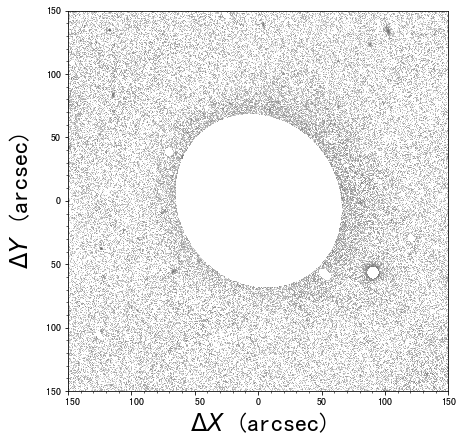

In [5]:
img = imgs[0]
mean, med, std = img.sigma_clipped_stats()
vmin = med - 0 * std
vmax = med + 100 * std
img.plot(vmin=vmin, vmax=vmax, a=1e-3)
plt.show()

### 1.3 sigmaimage & PSFs

In [6]:
ss_paths=[]
sigma_paths=[]
psf_paths=[]
for loop in range(5):
    ss_paths.append('/Users/liruancun/Works/GitHub/MorphSED/examples/data/{0}_ssim.fits'.format(band_list[loop]))
    sigma_paths.append('/Users/liruancun/Works/GitHub/MorphSED/examples/data/{0}_sigmap.fits'.format(band_list[loop]))
    psf_paths.append('/Users/liruancun/Works/GitHub/MorphSED/examples/data/{0}_psf.fits'.format(band_list[loop]))

#### construct

In [7]:
imgs.sky_subtraction(filepaths=ss_paths)
    

In [8]:
for loop in range(5):
    imgs[loop].cal_sigma_image(sigma_paths[loop])

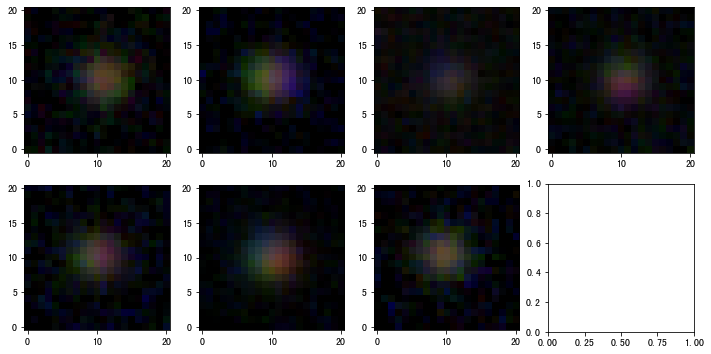

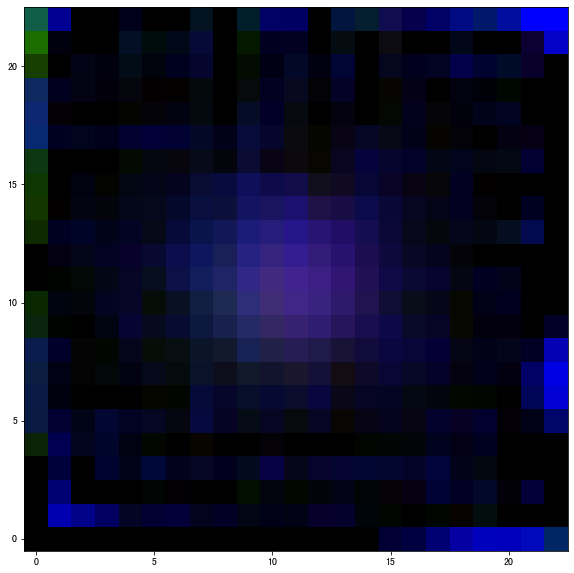

In [8]:
imgs.generate_PSFs(plot=[0,2,4],filepaths=psf_paths)

#### read from file

In [7]:
for loop in range(5):
    imgs[loop].read_ss_image(ss_paths[loop])
    imgs[loop].read_sigmap(sigma_paths[loop])
    imgs[loop].read_PSF(psf_paths[loop])

In [19]:
names  = ['%s_%s' % (profile, prop) for prop,profile in itertools.product(('xcen','ycen','mag','re','nser','ang','axrat','box'), ('sersic1','sersic2'))]
model0 = np.array((50, 50, 50, 50, 6.704, 6.2553, 10, 35, 3.0, 1.0, 180/np.pi-90, 180/np.pi-90, 1.,    0.5, 0,     0))
tofit  = np.array((True,  False, True,  False, True,  True,  True, True, True, False, True,  True,  True, True,  False,  False))
tolog  = np.array((False, False, False, False, False, False, True, True, True, True,  False, False, True,  True,  False, False))
#sigmas = np.ones_like(model0,dtype = float)
sigmas = np.array((2,     2,     2,     2,     5,     5,     1,    1,       1,    1,     30,    30,   0.3,   0.3,   0.3,   0.3))
lowers = np.array((0,     0,     0,     0,     10,    10,    0,    0,      -1,   -1,   -180,  -180,    -1,    -1,    -1,    -1))
uppers = np.array((1e3,   1e3,   1e3,   1e3,   30,    30,    2,    2,     1.3,  1.3,    360,   360, -0.01, -0.01,     1,     1))
priors = np.array([prior_func(s) for s in sigmas])

In [8]:
cat = img.sources_catalog


In [12]:
print (cat['ra'][0])


54.849682185454505


In [54]:
from astropy.table import Table, Column

In [55]:
tab = Table(cat)

In [58]:
print (tab['xcentroid'][0])

259.0860042988292


In [12]:
import cv2,lmfit
from astropy.nddata import NDData
from photutils.psf import extract_stars
import matplotlib.colors as colors
from photutils import EPSFBuilder

In [70]:
hdu = fits.open(flist[0])